# Using Decision Trees with the Fragile Families data

Things to keep in mind:

**Decision Trees**

* Decision trees are used for **classification** - that is, they sort input into separate buckets (assign the input to categorical variables). Today, we will use decision trees to predict one of 13 possible GPA values (values from 1.0 to 4.0 which lie 0.25 apart). We will treat these GPA values as completely distinct values, ignoring that they are consecutive, because that is what decision trees require.


* We will use three input variables for decision trees. These input variables (or **predictors**) do not need to be discrete.

In [1]:
# import libraries
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys, os
from sklearn.metrics import accuracy_score
import sys
import ff_functions as fff # this is the library we are providing for you to perform common operations on data

# The Fragile Families Challenge Data
Let's remind ourselves of the structure of the Fragile Families Data. The data has been collected over 15 years at 5 separate time points (Birth, Year 1, Year 3, Year 5, Year 9 and Year 15). At each stage, different surveys have been conducted:

![caption](images/challenge_data.png)

The Fragile Families Challenge is aimed at predicting 6 outcomes from year 15:
* GPA
* grit
* material hardship
* housing eviction
* layoff of a caregiver
* job training for a caregiver

based on 12,000 features from birth to age 9.

The data has been split into four main chunks:

![caption](images/challenge_matrix.png)

We are provided with two of the four chunks: 
* the **background**, or predictor, chunk, containing all 12,000 features from birth to age 9 (which we have been working with so far)
* the **training**, or outcome, chunk, containing 6 features from year 15.
The other two chunks are not published - that's because the challenge creators want to prevent the competitors from *training on the test data* - the submitted algorithms are tested first on the **leaderboard** chunk of the outcomes, and then the **holdout** data, to determine whether the algorithms *generalize* well.

The `ai4all_data` folder contains 3 csv files.

The data we've been working with so far (**background**)
* `background.csv`

The **training** chunk above has been split into two additional chunks for us:
* `train.csv`
* `test.csv`

That's because it's not enough that the challenge organizers test our algorithms on holdout data - the only way we can make sure our algorithms generalize well before submission is by testing them ourselves on held out data!

Let's load the data

In [2]:
# TODO: make sure the paths are correct

# directory with output data
background = "../../../ai4all_data/background.csv"
train = "../../../ai4all_data/train.csv"
test = "../../../ai4all_data/test.csv"

# all background variables
data_frame = pd.read_csv(background, low_memory=False)
data_frame = data_frame.set_index('challengeID')

# six Fragile Families challenge outcome variables 
outcome = pd.read_csv(train, low_memory=False)
outcome = outcome.set_index('challengeID')

# six Fragile Families challenge outcome variables 
outcome_test = pd.read_csv(test, low_memory=False)
outcome_test = outcome_test.set_index('challengeID')

In [3]:
outcome.head()

,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,3.50,0.090909,0.0,0.0,0.0
7,2.5,3.25,0.000000,0.0,0.0,0.0
8,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
outcome_test.head()

,gpa,grit,materialHardship,eviction,layoff,jobTraining
challengeID,,,,,,
2,NaN,3.50,0.000000,False,False,False
4,3.00,3.25,0.000000,True,False,False
11,3.25,4.00,0.181818,False,True,True
15,2.75,4.00,0.000000,False,False,True
17,3.25,3.50,0.363636,False,True,False


Observe that challengeID are not all consecutive numbers - that's because the indices have been randomly selected to belong to the test and train splits.

# Exercise 1
How many of the 4,200 outcomes are provided? What percent of those is in the test split? Train split? How many are witheld?  

# Exericise 2
We are interested in predicting GPA. Look at the variables in the data set and write out 5 ideas of the variables you'd expect to be correlated with GPA:

Let's start by studying three variables:
* t5c13a: literacy skills
* t5c13b: social science skills
* t5c13c: math skills

It intuitively makes sense they would be correlated with GPA (it's a little bit of a cheat: other people have already found it for us!).
    
Let's have a closer look at the data. We have three predictor variables: t5c13a, t5c13b and t5c13c. Let's look at the values they contain:

In [5]:
print(data_frame.t5c13a.unique())
print(data_frame.t5c13b.unique())
print(data_frame.t5c13c.unique())

[-9  3  1  4  2 -1  5 -2 -3]
[-9  3  2  4  1 -1  5 -2 -3]
[-9  2  4  3  1 -1  5 -2 -3]


To see how often a given value occurs, we can use the "value_counts" function

In [6]:
print(data_frame.t5c13a.value_counts())

-9    2228
 3     728
 2     531
 4     441
 1     193
 5     107
-2       7
-1       6
-3       1
Name: t5c13a, dtype: int64


# Question
What do the negative values signify? Use the metadata website (http://metadata.fragilefamilies.princeton.edu/) to find out.

Now, look at the different values of GPA that occur in the table. You can also look at their frequency:

In [7]:
print(outcome.gpa.unique())
print(outcome.gpa.value_counts(dropna=False))

[  nan  2.5   2.25  3.25  2.75  2.    3.    3.5   4.    3.75  1.25  1.5
  1.75  1.  ]
NaN      956
 3.25    170
 3.00    157
 2.75    147
 2.50    134
 3.50    128
 2.25    114
 4.00     78
 3.75     73
 2.00     62
 1.75     56
 1.50     34
 1.25      7
 1.00      5
Name: gpa, dtype: int64


Notice that there are a ton of missing values (NaN). We will only be using a small portion of the dataset that contains non-missing values.

We will only keep the students who 

* have the GPA variable (select the only the students in data_frame that haven't been removed from outcome)

* do not have missing values for any of the three categories we're interested in: language and literacy skills ('t5c13a'), social science skills ('t5c13b'), math skills ('t5c13c')

And remove the other ones

Observe that the challengeID reflects which rows remain in the outcome DataFrame after NaN removal.


In [8]:
GPA = fff.pick_ff_variables(outcome,['gpa'],remove_nans=True,remove_negatives=True)
predictors = fff.pick_ff_variables(data_frame,['t5c13a', 't5c13b', 't5c13c'],remove_nans=True,remove_negatives=True)

Data frame with  1165  rows and  1 columns.
Data frame with  1982  rows and  3 columns.


We removed the rows with negative and NaN values in both GPA and predictors. Let's now find the list of indices that overlap between the two lists:

In [9]:
# Choose only those students (rows of data_frame) whose GPA value is not missing
rows_remaining_outcome = GPA.index.values
rows_remaining_predictors = predictors.index.values

In [10]:
# find their intersection
overlap = []
for el in rows_remaining_predictors:
    if el in rows_remaining_outcome:
        overlap.append(el)

In [11]:
len(overlap)

734

In [12]:
Y = GPA.loc[overlap]
X = predictors.loc[overlap]

In [13]:
# Let's again have a closer look at the data. We have three predictor variables: t5c13a, t5c13b and t5c13c.
print(X.t5c13a.value_counts())
print(X.t5c13b.value_counts())
print(X.t5c13c.value_counts())
print(Y.gpa.value_counts())

3    281
2    174
4    165
1     76
5     38
Name: t5c13a, dtype: int64
3    397
4    141
2    127
1     48
5     21
Name: t5c13b, dtype: int64
3    314
4    168
2    159
1     64
5     29
Name: t5c13c, dtype: int64
3.25    104
3.00     96
2.75     95
2.50     82
3.50     81
2.25     73
4.00     54
3.75     51
2.00     36
1.75     30
1.50     23
1.25      5
1.00      4
Name: gpa, dtype: int64


In [14]:
print(len(Y.gpa.unique()))

13


We see that all three columns contain 5 unique categories. 

The GPA is also put into 13 unique categories (although it could be a continuous variable, in this case it's been collected as a discrete variable). 

Decision trees need discrete outcomes (since they are used for classification, not regression). We need to change their data type from Float to String (this will treat them as labels, not numbers)

In [15]:
GPA = Y.gpa.astype('str')

# 2. Decision Trees

In [16]:
# First, let's split our data into train and test sets
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, GPA, test_size = 0.3, random_state = 100)

//anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
y_pred = clf.predict(X_test).astype(float)

### Draw the tree graph

In [19]:
# Functions for plotting trees

from sklearn.tree import export_graphviz
import graphviz
def show_tree(treeGraph, out_file, features=None, classes=None):
    export_graphviz(clf_changed, out_file, feature_names=features, class_names=classes, filled=True)
    with open(out_file) as f:
        dot_graph = f.read()
    graph = graphviz.Source(dot_graph)
    return graph

from sklearn import tree
import pydotplus
from IPython.display import Image
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
def save_tree(treeGraph, out_file, features=None, classes=None):
    dot_data = tree.export_graphviz(treeGraph, out_file=None, feature_names=features, class_names=classes, filled=True)
    graph = pydotplus.graph_from_dot_data(dot_data)
    graph.write_svg("tree.svg")
    # convert svg to png
    drawing = svg2rlg("tree.svg")
    renderPM.drawToFile(drawing, out_file)

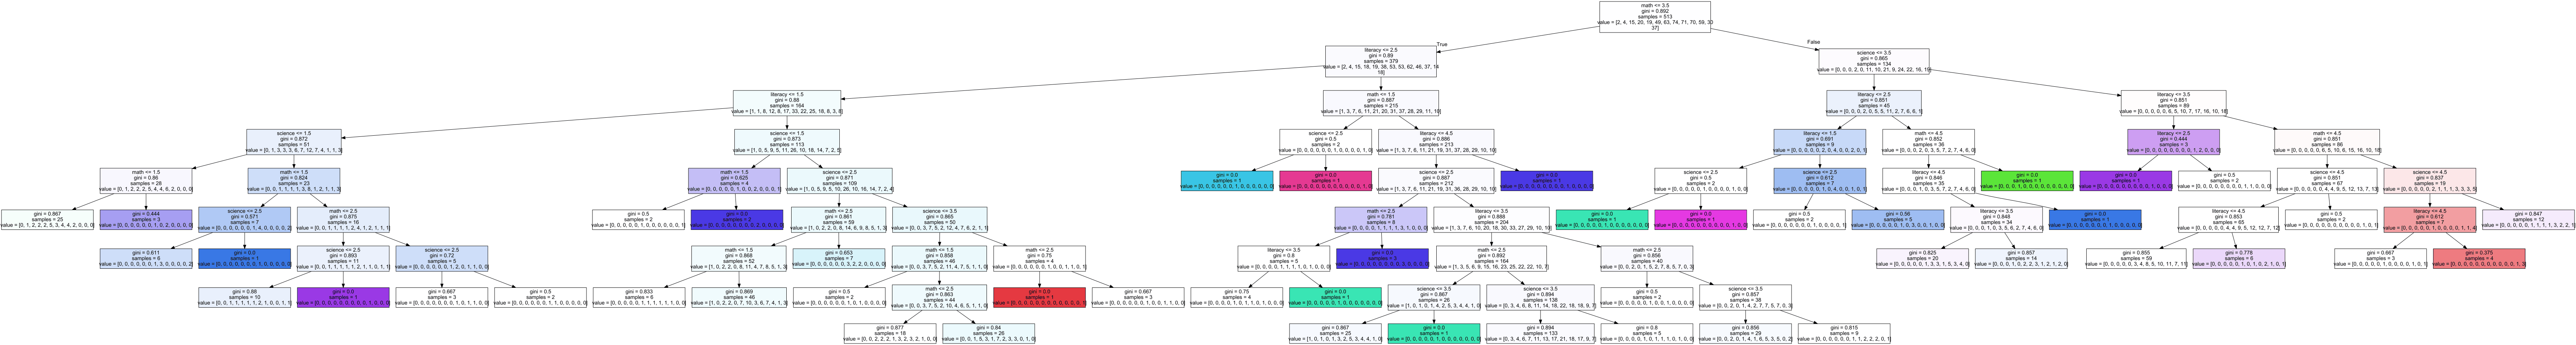

In [20]:
# Save and display generated tree 
our_features = ['literacy','science','math']
our_classes = ['1.0', '1.25', '1.5', '1.75', '2.0', '2.25', '2.5', '2.75', '3.0','3.25', '3.5', '3.75', '4.0', 'NaN']
our_filename = "mytree.png"
save_tree(clf, out_file = our_filename, features = our_features)#, classes = our_classes)
i = Image(filename = our_filename)
i

### Exercise
Look at the generated tree. Find the leaves with label 4.0. What rules did the algorithm follow to classify students as having a 4.0 GPA? Do these rules make sense? Why?

Now do the same with a 2.0 GPA. Are the rules generated to make those predictions more/less logical? Why?

### Now, let's evaluate the accuracy of our predictions

In [21]:
# What is the accuracy on the training set? 
train_pred = clf.predict(X_train)
train_acc = sum(train_pred==y_train.values)/train_pred.shape[0]
print("Training accuracy is", train_acc)

# What is the accuracy on the test set? 
test_pred = clf.predict(X_test)
test_acc = sum(test_pred==y_test.values)/test_pred.shape[0]
print("Training accuracy is", test_acc)

Training accuracy is 0.253411306043
Training accuracy is 0.131221719457


### Find mean squared error of prediction

In [22]:
sum(test_pred==y_test.values)
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(test_pred, y_test.values))

0.71208857296449179

### Changing parameters
We only used the default values in the tree. Let's see again what things we can modify when calling the tree method.

In [23]:
DecisionTreeClassifier()

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Among the simplest things, we can edit the depth of the tree, the maximum number of leaf nodes, minimum number of leaves fer leaf. 

1. Think about how changing each of the three elements can change the accuracy or the way data is used.

2. Try editing those variables and see if you can increase the accuracy. 

max_depth 5
max_leaf_nodes 10
min_samples_leaf 1
Training accuracy is 0.216374269006
Training accuracy is 0.10407239819


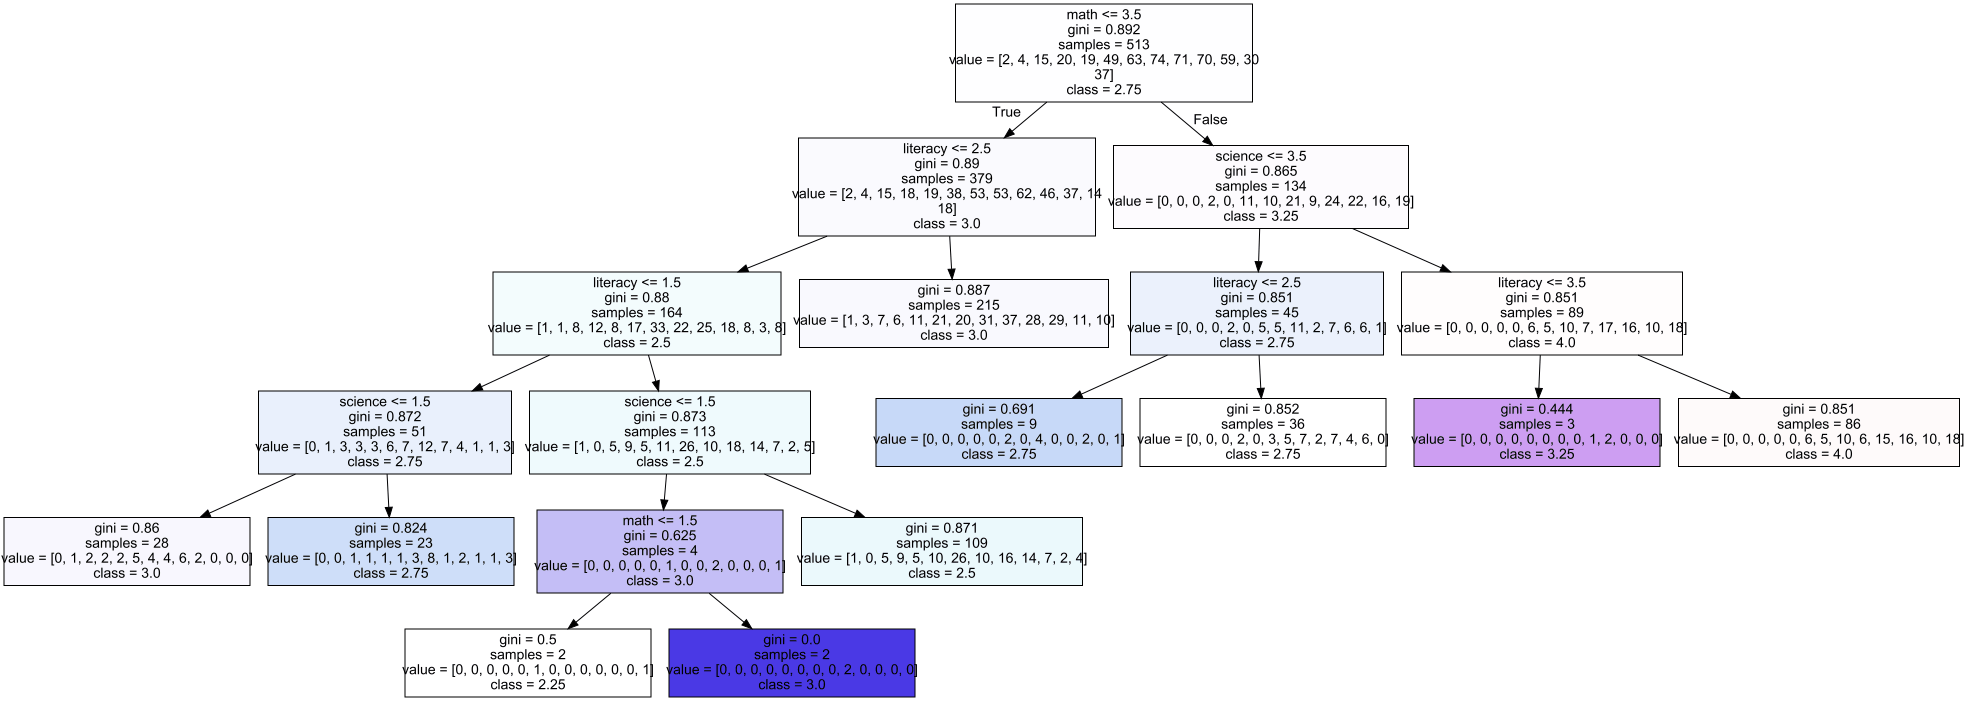

In [24]:
# edit this code

clf_changed = DecisionTreeClassifier(max_depth=5, max_leaf_nodes=10, min_samples_split=3)
clf_changed.fit(X_train, y_train)

# Print parameters used
print("max_depth", clf_changed.max_depth)
print("max_leaf_nodes", clf_changed.max_leaf_nodes)
print("min_samples_leaf", clf_changed.min_samples_leaf)

# What is the accuracy on the training set? 
train_pred = clf_changed.predict(X_train)
train_acc = sum(train_pred==y_train.values)/train_pred.shape[0]
print("Training accuracy is", train_acc)

# What is the accuracy on the test set? 
test_pred = clf_changed.predict(X_test)
test_acc = sum(test_pred==y_test.values)/test_pred.shape[0]
print("Training accuracy is", test_acc)

# Display the generated tree
our_features = ['literacy','science','math']
our_classes = ['1.0', '1.25', '1.5', '1.75', '2.0', '2.25', '2.5', '2.75', '3.0','3.25', '3.5', '3.75', '4.0']
our_filename = "mytree_changed.png"
save_tree(clf_changed, out_file = our_filename, features = our_features, classes = our_classes)
i = Image(filename = our_filename)
i

Report the values and parameters you found below:

1)

2)

3)